## Классификация новостей [AG's News Topic Classification Dataset](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv)

Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

Для ускорения обучения сети рекомендуется подключить GPU (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


2025-11-30 13:06:21.007636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Enable to see which operations are assigned to the GPU
tf.debugging.set_log_device_placement(False)  # Set to True for detailed logs

# Confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Максимальное количество уникальных слов слов
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

## Загрузка набора данных

Загружаем данные для обучения

In [4]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv -O train.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-11-30 13:06:25--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2025-11-30 13:06:25--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: 'train.csv'

train.csv           100%[===================>]  28.10M  3.74MB/s    in 7.3s    

2025-1

Загружаем данные для тестирования

In [5]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv -O test.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-11-30 13:06:33--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv [following]
--2025-11-30 13:06:34--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857427 (1.8M) [text/plain]
Saving to: 'test.csv'

test.csv            100%[===================>]   1.77M  3.53MB/s    in 0.5s    

2025-11-30

Загружаем имена классов

In [6]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt -O classes.txt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-11-30 13:06:35--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31 [text/plain]
Saving to: 'classes.txt'

classes.txt         100%[===================>]      31  --.-KB/s    in 0s      

2025-11-30 13:06:35 (1.82 MB/s) - 'classes.txt' saved [31/31]



## Просматриваем данные

In [7]:
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
classes.txt  lab_4_ktuner.ipynb   lab_4_manual.ipynb	test.csv   wget-log
lab_3.ipynb  lab_4_ktuner2.ipynb  nlp_class_news.ipynb	train.csv


In [8]:
!cat classes.txt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
World
Sports
Business
Sci/Tech


In [9]:
!head train.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
"3","Wall St. Bears Claw Back Into the Black (Reuters)","Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
"3","Carlyle Looks Toward Commercial Aerospace (Reuters)","Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
"3","Oil and Economy Cloud Stocks' Outlook (Reuters)","Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums."
"3","Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)","Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Sat

In [10]:
!head test.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
"3","Fears for T N pension after talks","Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
"4","The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com)","SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
"4","Ky. Company Wins Grant to Study Peptides (AP)","AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
"4","Prediction Unit Helps Forecast Wildfires (AP)","AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and e

In [11]:
!wc -l train.csv
!wc -l test.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
120000 train.csv
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
7600 test.csv


## Загружаем данные в память

Читаем данные из файла

In [12]:
train = pd.read_csv('train.csv',
                    header=None,
                    names=['class', 'title', 'text'])

In [13]:
train

,class,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Выделяем данные для обучения

In [14]:
news = train['text']
# news = train['title'] + ' ' + train['text']

In [15]:
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

Выделяем правильные ответы

In [16]:
# Преобразование целочисленного вектора класса в двоичную матрицу
# Аргументы: вектор классов в данных и общее количество классов
y_train = utils.to_categorical(train['class'] - 1, nb_classes)

In [17]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], shape=(120000, 4))

## Токенизация текста

In [18]:
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

Создаем токенизатор Keras

<img src="https://habrastorage.org/r/w1560/getpro/habr/upload_files/bc9/feb/314/bc9feb3143af4759aceff629305cf8ae.png">

Принцип работы модуля TextVectorization

In [19]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=num_words,
    output_mode='int',
    output_sequence_length=max_news_len)

I0000 00:00:1764497198.715353  231718 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [20]:
vectorize_layer.adapt(news)
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('to'),
 np.str_('of'),
 np.str_('in'),
 np.str_('and'),
 np.str_('on'),
 np.str_('for'),
 np.str_('that'),
 np.str_('39s'),
 np.str_('with'),
 np.str_('as'),
 np.str_('its'),
 np.str_('at'),
 np.str_('is'),
 np.str_('said'),
 np.str_('by'),
 np.str_('it'),
 np.str_('has'),
 np.str_('new'),
 np.str_('an'),
 np.str_('from'),
 np.str_('his'),
 np.str_('us'),
 np.str_('will'),
 np.str_('was'),
 np.str_('reuters'),
 np.str_('after'),
 np.str_('have'),
 np.str_('be'),
 np.str_('their'),
 np.str_('are'),
 np.str_('over'),
 np.str_('ap'),
 np.str_('he'),
 np.str_('but'),
 np.str_('two'),
 np.str_('first'),
 np.str_('this'),
 np.str_('more'),
 np.str_('monday'),
 np.str_('wednesday'),
 np.str_('tuesday'),
 np.str_('thursday'),
 np.str_('company'),
 np.str_('up'),
 np.str_('friday'),
 np.str_('inc'),
 np.str_('one'),
 np.str_('world'),
 np.str_('yesterday'),
 np.str_('they'),
 np.str_('last'),
 np.str_('york'),
 np.str_('against'),
 np.str_

In [21]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [22]:
tokenizer.fit_on_texts(news)

Просматриваем словарь токенизатора

In [23]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 '39': 9,
 's': 10,
 'that': 11,
 'with': 12,
 'as': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'is': 17,
 'by': 18,
 'it': 19,
 'has': 20,
 'new': 21,
 'an': 22,
 'from': 23,
 'reuters': 24,
 'his': 25,
 'will': 26,
 'was': 27,
 'after': 28,
 'have': 29,
 'be': 30,
 'their': 31,
 'two': 32,
 'are': 33,
 'us': 34,
 'over': 35,
 'quot': 36,
 'year': 37,
 'first': 38,
 'ap': 39,
 'he': 40,
 'but': 41,
 'gt': 42,
 'lt': 43,
 'this': 44,
 'more': 45,
 'monday': 46,
 'wednesday': 47,
 'one': 48,
 'tuesday': 49,
 'up': 50,
 'thursday': 51,
 'company': 52,
 'inc': 53,
 'friday': 54,
 'world': 55,
 'than': 56,
 'u': 57,
 '1': 58,
 'last': 59,
 'they': 60,
 'york': 61,
 'yesterday': 62,
 'against': 63,
 'about': 64,
 'who': 65,
 'not': 66,
 'were': 67,
 'into': 68,
 'out': 69,
 'three': 70,
 'been': 71,
 'president': 72,
 '2': 73,
 'had': 74,
 'million': 75,
 'corp': 76,
 'oil': 77,
 'when': 78,
 'week': 79,
 'time'

Преобразуем новости в числовое представление

In [24]:
sequences = tokenizer.texts_to_sequences(news)

Просматриваем новости в числовом представлении

In [25]:
index = 1
print(news[index])
print(sequences[index])

Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
[24, 863, 751, 371, 93, 84, 20, 2, 3916, 8, 453, 431, 6, 1308, 2799, 5, 1, 549, 237, 20, 3528, 2002, 14, 8267, 7, 216, 314, 4, 1, 131]


In [26]:
tokenizer.word_index['reuters']

24

Ограничиваем длину текста

In [27]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [28]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   24,  758, 7851,  433,
        5786, 2861,    4, 5916,   33, 3642,  831,  432],
       [  24,  863,  751,  371,   93,   84,   20,    2, 3916,    8,  453,
         431,    6, 1308, 2799,    5,    1,  549,  237,   20, 3528, 2002,
          14, 8267,    7,  216,  314,    4,    1,  131],
       [  24, 2199,  463,  105, 1568, 1484,   64,    1,  397,    6,    1,
        1026,    8,  317,   33,  178,    3, 6377,   35,    1,  311,  131,
          99,   79,  189,    1, 6120,    4,    1, 1068],
       [   0,   24,  713,   29, 5142,   77, 3549, 7993,   23,    1,  737,
        3199,    5,  493,  106,   28, 1402,  573,    2,  825, 2601,   90,
         760, 2559,   22,   77,  292,   16,    7,   97],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  165,
          55,   77,  105, 8851, 1776,    6, 8268, 3454,    2,   21,  343,
        3036,   70,  266,  151, 

## Сверточная нейронная сеть

In [29]:
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(keras.layers.Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(128, activation='relu'))
model_cnn.add(keras.layers.Dense(4, activation='softmax'))

/home/vad1mchk/projects/LabsDataAnalysisAndModeling/venv_tf/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [32]:
# model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_filepath_cnn = '/tmp/ckpt/checkpoint.model_cnn.keras'
checkpoint_callback_cnn = ModelCheckpoint(checkpoint_filepath_cnn,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [33]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5


2025-11-30 13:06:46.185730: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f6a68005f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-30 13:06:46.185791: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-30 13:06:46.233930: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 13:06:46.469163: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-30 13:06:46.518899: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 13:06:46.

 46/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2850 - loss: 1.3804

I0000 00:00:1764497212.006479  231969 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/844 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4529 - loss: 1.1849

2025-11-30 13:06:52.385953: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 13:06:52.386010: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 13:06:54.947598: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_471', 16 bytes spill stores, 16 bytes spill loads



844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7362 - loss: 0.6526
Epoch 1: val_accuracy improved from None to 0.87592, saving model to /tmp/ckpt/checkpoint.model_cnn.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8444 - loss: 0.4298 - val_accuracy: 0.8759 - val_loss: 0.3350
Epoch 2/5
837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9199 - loss: 0.2367
Epoch 2: val_accuracy improved from 0.87592 to 0.88925, saving model to /tmp/ckpt/checkpoint.model_cnn.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9158 - loss: 0.2473 - val_accuracy: 0.8892 - val_loss: 0.3079
Epoch 3/5
839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9385 - loss: 0.1811
Epoch 3: val_accuracy did not improve from 0.88925
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9334 - loss: 0.1924 - val_accuracy: 0.8755 - val_loss: 0.3461
Epoch 4/5
839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9549 - loss: 0.1314
Epoch 4: val_accuracy did not improve from 0.88925
8

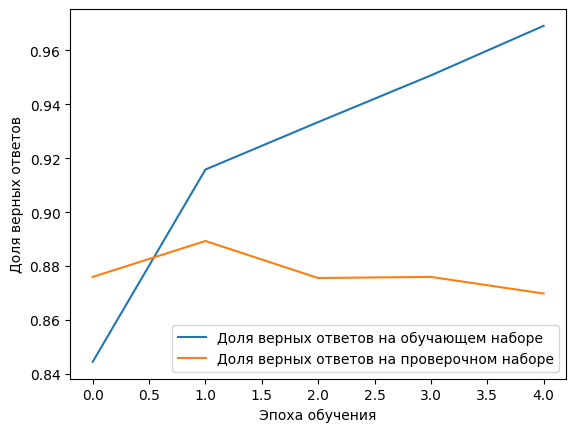

In [34]:
plt.plot(history_cnn.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [35]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(keras.layers.LSTM(16))
model_lstm.add(keras.layers.Dense(4, activation='softmax'))

In [36]:
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [38]:
# model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_filepath_lstm = '/tmp/ckpt/checkpoint.model_lstm.keras'
checkpoint_callback_lstm = ModelCheckpoint(checkpoint_filepath_lstm,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [39]:
history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7147 - loss: 0.7315
Epoch 1: val_accuracy improved from None to 0.88417, saving model to /tmp/ckpt/checkpoint.model_lstm.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8270 - loss: 0.4928 - val_accuracy: 0.8842 - val_loss: 0.3373
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9116 - loss: 0.2832
Epoch 2: val_accuracy improved from 0.88417 to 0.89075, saving model to /tmp/ckpt/checkpoint.model_lstm.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9088 - loss: 0.2848 - val_accuracy: 0.8907 - val_loss: 0.3129
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9277 - loss: 0.2318
Epoch 3: val_accuracy did not improve from 0.89075
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9226 - loss: 0.2420 - val_accuracy: 0.8870 - val_loss: 0.3202
Epoch 4/5
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9337 - loss: 0.2072
Epoch 4: val_accuracy did not i

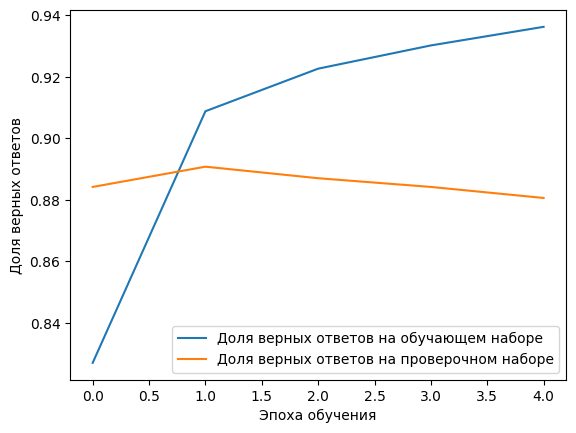

In [40]:
plt.plot(history_lstm.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [41]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(4, activation='softmax'))

In [42]:
model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model_gru.h5`

In [44]:
# model_gru_save_path = 'best_model_gru.h5'
checkpoint_filepath_gru = '/tmp/ckpt/checkpoint.model_gru.keras'
checkpoint_callback_gru = ModelCheckpoint(checkpoint_filepath_gru,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [45]:
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6503 - loss: 0.8696
Epoch 1: val_accuracy improved from None to 0.88467, saving model to /tmp/ckpt/checkpoint.model_gru.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7886 - loss: 0.5821 - val_accuracy: 0.8847 - val_loss: 0.3351
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9085 - loss: 0.2834
Epoch 2: val_accuracy improved from 0.88467 to 0.89192, saving model to /tmp/ckpt/checkpoint.model_gru.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9069 - loss: 0.2872 - val_accuracy: 0.8919 - val_loss: 0.3143
Epoch 3/5
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9256 - loss: 0.2333
Epoch 3: val_accuracy did not improve from 0.89192
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9208 - loss: 0.2437 - val_accuracy: 0.8846 - val_loss: 0.3301
Epoch 4/5
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9313 - loss: 0.2117
Epoch 4: val_accuracy did not imp

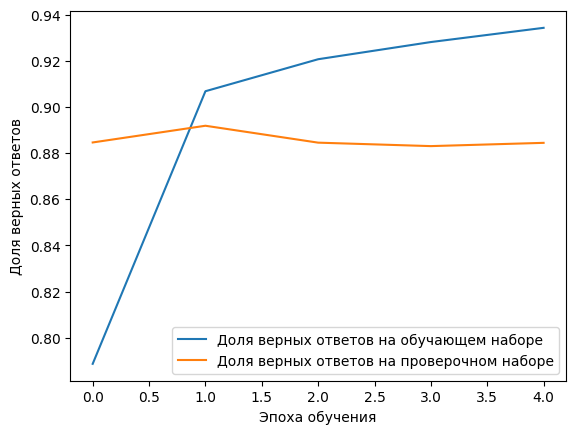

In [46]:
plt.plot(history_gru.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [47]:
test = pd.read_csv('test.csv',
                    header=None,
                    names=['class', 'title', 'text'])

In [48]:
test

,class,title,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


Преобразуем новости в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [49]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [50]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [51]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 2020, 3371,  449,   15, 6956,  252,   60,   33,
          28,  289,   12, 9088, 2184,  371,  169, 9284],
       [  92,  119,    4, 3472,    8,    1,  402,  134,   75, 5471, 1516,
        1227,    2, 3436,    8, 2744, 5220,  230,  936,   20, 2148,  117,
           1,   38,  561, 1974,    8,   14, 3957, 1218],
       [   2,   52, 5787,   18,    2, 4914,   15,    1,  525,    4, 4586,
         227,    2, 3922,    3, 1316,    2, 6888,    4, 2893,  576,   84,
          33,  758, 6515,    4,    1, 1013, 5154,    4],
       [9642, 1291,    6, 8714,   41,  671,   40, 2977,  177,    1,  108,
          26, 1027, 7300,   26,  760,    5, 3356,   40, 1271, 2450,   26,
        2170,   50, 3356,   26, 7415,    6, 9153,   26],
       [   0,    0,    0,    0,    0,    0,   39,  493, 7343,  832,  400,
         820,   28, 3827,    4,    1, 4474,   54, 9411,    1, 1273,   38,
        1230,    3, 1365,  348, 

Правильные ответы

In [52]:
y_test = utils.to_categorical(test['class'] - 1, nb_classes)

In [53]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], shape=(7600, 4))

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть

In [54]:
model_cnn.load_weights(checkpoint_filepath_cnn)

In [55]:
model_cnn.evaluate(x_test, y_test, verbose=1)

2025-11-30 13:10:04.057721: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 13:10:06.615622: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 40 bytes spill stores, 40 bytes spill loads



238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8954 - loss: 0.3128


[0.3128320276737213, 0.8953947424888611]

### Сеть LSTM

In [56]:
model_lstm.load_weights(checkpoint_filepath_lstm)

In [57]:
model_lstm.evaluate(x_test, y_test, verbose=1)

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8951 - loss: 0.3138


[0.3138119578361511, 0.8951315879821777]

### Сеть GRU

In [58]:
model_gru.load_weights(checkpoint_filepath_gru)

In [59]:
model_gru.evaluate(x_test, y_test, verbose=1)

238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8943 - loss: 0.3196


[0.3196309506893158, 0.8943421244621277]

## Задание

1. Попробовать улучшить предсказание моделей за счет использования не только текста, но и заголовка новости.
При этом рекомендуется увеличить максимальню длину текста. <br/>
2. Проверить, как на качеаство предсказания влияет предобработка текста (удаление стоп-слов, пунктуации, лемматизация и др.)
3. Применить методы регуляризации для устранения переобучения моделей.


## Стоп-слова и пунктуация

**Стоп-слова** - это слова, которые часто встречаются практически в любом тексте и не несут полезной информации о конретном документе. Для модели это просто шум. А шум нужно убирать. По аналогичной причине убирают и пунктуацию.

In [60]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vad1mchk/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/vad1mchk/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/vad1mchk/nltk_data...


True

In [61]:
# импортируем стоп-слова из библиотеки nltk
from nltk.corpus import stopwords

# посмотрим на стоп-слова для английского языка
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

*Знаки* пунктуации лучше импортировать из модуля **String**. В нем хранятся различные наборы констант для работы со строками (пунктуация, алфавит и др.).

In [62]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'



Объединим стоп-слова и знаки пунктуации вместе и запишем в переменную noise:


In [63]:
noise = stopwords.words('english') + list(punctuation)

## Лемматизация

**Лемматизация** – это сведение разных форм одного слова к начальной форме – **лемме**. Почему это хорошо?
* Во-первых, естественно рассматривать как отдельный признак каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

In [64]:
from nltk.stem import WordNetLemmatizer

In [65]:
lemmatizer = WordNetLemmatizer()

In [66]:
news = list(lemmatizer.lemmatize(word) for word in news)

## Полезные ссылки

1. [Как понять LSTM сети](https://alexsosn.github.io/ml/2015/11/17/LSTM.html)
2. [Рекуррентные нейронные сети в Keras](https://keras.io/layers/recurrent/)
3. [Регуляризуем правильно!](https://telegra.ph/Regulyarizuem-pravilno-09-20)
4. [12 основных методов Dropout](https://towardsdatascience.com/12-main-dropout-methods-mathematical-and-visual-explanation-58cdc2112293?source=topic_page---------6------------------1)